# Exploration done on the EPFL recommender system

# Data Retrieval

In [1]:
import configparser
import matplotlib.pyplot as plt
import mysql.connector as sql
import numpy as np
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('../config/credentials.ini')
db_connection = sql.connect(host=credentials.get('mysql', 'url'),
                            database='semester_project_romain',
                            user=credentials.get('mysql', 'username'),
                            password=credentials.get('mysql', 'password'))

In [2]:
# Found courses that should be removed:
# Génie nucléaire, Ingenierie financiere:
# useless, most courses compulsatory
courses_to_remove = [
    "Admission année sup.",
    "Projet de master en systèmes de communication",
    "SHS : Introduction au projet",
    "Cycle master",
    "Projet de Master",
    "Groupe Core courses & options",
    "Bloc Projets et SHS",
    "Groupe 2 : Options",
    "Master SC",
    "Mineur",
    "Groupe 1",
    "Projet en systèmes de communication II",
    "Projet en informatique II",
    "Projet de master en informatique",
    "Cours réservés spécifiquement aux étudiants s'inscrivant pour le mineur Area and Cultural Studies",
    "SHS : Projet",
    "Optional project in communication systems",
    "Optional project in computer science",
    "Mineur : Neurosciences computationnelles",
    "Stage d'ingénieur crédité avec le PDM (master en Systèmes de communication)",
    "Stage d'ingénieur crédité avec le PDM (master en Informatique)",
    "Cours UNIL - Faculté des hautes études commerciales HEC I (printemps)",
    "Chemical engineering of heterogenous reactions",
    "Process development I",
    "Chemical engineering lab & project",
    "Stage d'ingénieur (master en Génie chimique et Biotechnologie)",
    "Projet de master en génie chimique et biotechnologie",
    "Interdisciplinary project",
    "Projet de master en chimie moléculaire et biologique",
    "Project in molecular sciences",
    "Superstudio",
    "Enoncé théorique de master",
    "De la structure à l'ornement",
    "Projet de master en architecture",
    "Pré-étude projet de master",
    "Projet SIE/ENAC",
    "Projet de master en sciences et ingénierie de l'environnement",
    "Stage d'ingénieur crédité avec le PDM (master en Sciences et ingénierie de l'environnement)",
    "Projet de master en génie électrique et électronique",
    "Projet Génie mécanique II",
    "Projet Génie mécanique I",
    "Stage d'ingénieur crédité avec le PDM (master en Génie mécanique)",
    "Projet de master en génie mécanique",
    "Research project in materials I",
    "Projet de master en science et génie des matériaux",
    "Stage d'ingénieur crédité avec le PDM (master en Science et génie des matériaux)",
    "Projet microtechnique I",
    "Projet de master en microtechnique",
    "Stage d'ingénieur crédité avec le PDM (master en Microtechnique)",
    "Projet de master en mathématiques",
    "Projet de Mathématiques (master)",
    "Stage d'ingénieur (master en Ingénierie mathématique)",
    "Projet de master en mathématiques",
    "Projet de Mathématiques (master)",
    "Stage d'ingénieur crédité avec le PDM (master en Ingénierie mathématique)",
    "Stage d'ingénieur (master en Bioingénierie)",
    "Projet de master en bioingénierie et biotechnologie",
    "Stage d'ingénieur (master en Sciences et technologie du vivant)",
    "Projet de master en sciences et technologies du vivant",
    "Stage d'ingénieur (master en Génie nucléaire)",
    "Projet de master en génie nucléaire",
    "Stage d'ingénieur (master en Ingénierie physique)",
    "Projet de master en physique",
    "Stage d'ingénieur (master en Sciences et ingénierie computationnelles)",
    "Projet de master en science et ingénierie computationelles",
    "Projet CSE I",
    "Projet CSE II",
    "Project in energy management and sustainability I",
    "Stage d'ingénieur crédité avec le PDM (master en Gestion de l'énergie et construction durable)",
    "Stage d'ingénieur (master en Génie électrique et électronique)",
]

domains_to_remove = [
    "Humanities and social sciences",
    "Programme Sciences humaines et sociales",
]

In [6]:
units = {
     'Architecture': 'AR',
     'Bioingénierie': 'SV_B',
     'Chimie moléculaire et biologique': 'CGC_CHIM',
     "Gestion de l'énergie et construction durable": 'EME_MES',
     'Génie chimique et biotechnologie': 'CGC_ING',
     'Génie civil': 'GC',
     'Génie mécanique': 'GM',
     'Génie nucléaire': 'PH_NE',
     'Génie électrique et électronique': 'EL',
     'Informatique': 'IN',
     'Ingénierie financière': 'IF',
     'Ingénierie mathématique': 'ING_MATH',
     'Ingénierie physique': 'ING_PHYS',
     'Management, technologie et entrepreneuriat': 'MTEE',
     'Mathématiques - master': 'MATH',
     'Micro and Nanotechnologies for Integrated Systems': 'MNIS',
     'Microtechnique': 'MT',
     'Physique - master': 'PHYS',
     'Science et génie des matériaux': 'MX',
     'Science et ingénierie computationnelles': 'MA_CO',
     "Sciences et ingénierie de l'environnement": 'SIE',
     'Sciences et technologies du vivant - master': 'SV_STV',
     'Systèmes de communication - master': 'SC_EPFL'
}

all_info = """
            select distinct 
                PersonID, 
                PedagogicalCode, 
                StudyDomain, 
                UnitName, 
                UnitID, 
                UnitCode,
                SubjectName, 
                Course_Enrolments.SubjectID,
                SectionName, 
                CourseCode,
                YearName
            from 
                Course_Enrolments
                inner join 
                Course_Codes 
                    on Course_Codes.planid = course_enrolments.planid 
                    and Course_Codes.subjectid = course_enrolments.subjectid
            where 
                {}
                and LevelName = "Master"
            """.format("UnitName = \"{}\"".format(list(units.keys())[2]))

all_df = pd.read_sql(all_info, con=db_connection)
all_df = all_df[~all_df.SubjectName.isin(courses_to_remove)]
# Removing the SHS courses
all_df = all_df[~(all_df.StudyDomain.isin(domains_to_remove))]
# Mapping of subject ids to subject names
subject_mapping = all_df[['SubjectID', 'SubjectName']].drop_duplicates()
all_df

,PersonID,PedagogicalCode,StudyDomain,UnitName,UnitID,UnitCode,SubjectName,SubjectID,SectionName,CourseCode,YearName
0,1453220010,MA1,Life sciences,Chimie moléculaire et biologique,249519,CGC_CHIM,Cellular biology and biochemistry for engineers,71603711,Science et génie des matériaux,BIO-105,2012-2013
1,128920325,BA5,Life sciences,Chimie moléculaire et biologique,249519,CGC_CHIM,Biologie moléculaire,350468544,Chimie et génie chimique,BIO-201,2013-2014
2,57901345,BA5,Life sciences,Chimie moléculaire et biologique,249519,CGC_CHIM,Biologie moléculaire,350468544,Chimie et génie chimique,BIO-201,2011-2012
3,172647551,MA2,Life sciences,Chimie moléculaire et biologique,249519,CGC_CHIM,Biomolecular structure and mechanics,271439550,Bioingénierie,BIO-315,2011-2012
4,224831782,BA5,Life sciences,Chimie moléculaire et biologique,249519,CGC_CHIM,Microbiology,260077392,Sciences et technologies du vivant,BIO-372,2012-2013
5,134023454,BA5,Life sciences,Chimie moléculaire et biologique,249519,CGC_CHIM,Microbiology,260077392,Sciences et technologies du vivant,BIO-372,2012-2013
6,128920325,BA5,Life sciences,Chimie moléculaire et biologique,249519,CGC_CHIM,Microbiology,260077392,Sciences et technologies du vivant,BIO-372,2013-2014
7,901865061,BA5,Life sciences,Chimie moléculaire et biologique,249519,CGC_CHIM,Microbiology,260077392,Sciences et technologies du vivant,BIO-372,2014-2015
8,224831782,BA5,Life sciences,Chimie moléculaire et biologique,249519,CGC_CHIM,Génétique et génomique,1584778525,Sciences et technologies du vivant,BIO-373,2012-2013
9,134023454,BA5,Life sciences,Chimie moléculaire et biologique,249519,CGC_CHIM,Génétique et génomique,1584778525,Sciences et technologies du vivant,BIO-373,2012-2013


## Creating the binary matrix

In [4]:
courses_matrix = all_df[['PersonID', 'SubjectName']]
courses_matrix = courses_matrix.drop_duplicates()
courses_matrix = courses_matrix.set_index(['PersonID', 'SubjectName'])

def series_to_integers(series):
    "Converts a whole series to integers"
    return pd.to_numeric(series, downcast='integer')

# If the course was taken, set it to 1
courses_matrix['joined'] = 1
courses_matrix = courses_matrix.reset_index().pivot(index='PersonID', columns='SubjectName', values='joined')
courses_matrix = courses_matrix.fillna(0)
courses_matrix = courses_matrix.apply(series_to_integers)

# Removing all students that took less than five courses
MIN_COURSES_BY_STUDENT = 10
courses_matrix =courses_matrix[np.sum(courses_matrix == 1, axis=1) > MIN_COURSES_BY_STUDENT]
courses_matrix

SubjectName,Accounting for finance,Advanced algorithms,Advanced analysis I,Advanced analysis II,Advanced compiler construction,Advanced computer architecture,Advanced computer graphics,Advanced computer networks and distributed systems,Advanced cryptography,Advanced databases,...,Topics in theoretical computer science,Traitement automatique de la parole,Traitement quantique de l'information,Traitement quantique de l'information I,Traitement quantique de l'information II,Unsupervised and reinforcement learning in neural networks,VLSI design I,VLSI design I + EDA TP,VLSI design II,Virtual reality
PersonID,,,,,,,,,,,,,,,,,,,,,
2412404,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2414145,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2416702,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2436004,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2480734,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2501514,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2501538,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2505593,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2523797,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Co-enrolment matrix
## Most taken courses
We need to find a way to get a cleaner dataset of courses, a lot of them are not usefull or outdated and should not be recommended.

In [8]:
# Taking a look at the most taken courses
registrations_df = all_df.set_index(['SubjectName', 'YearName'])
registrations_df

PersonID  \
SubjectName                                        YearName                
Cellular biology and biochemistry for engineers    2012-2013  1453220010   
Biologie moléculaire                               2013-2014   128920325   
                                                   2011-2012    57901345   
Biomolecular structure and mechanics               2011-2012   172647551   
Microbiology                                       2012-2013   224831782   
                                                   2012-2013   134023454   
                                                   2013-2014   128920325   
                                                   2014-2015   901865061   
Génétique et génomique                             2012-2013   224831782   
                                                   2012-2013   134023454   
Génétique                                          2011-2012   116987366   
Physiologie par Systèmes I                         2011-2012    57901345   
Physiologie par Systèmes II                        2012-2013   224831782   
                                                   2012-2013   134023454   
Neurophysiologie                                   2008-2009     2502140   
Introduction to oncology                           2012-2013   224831782   
Stem cell biology and technology                   2008-2009    35478972   
                                                   2012-2013   254696052   
                                                   2013-2014  1689383073   
                                                   2013-2014   224831782   
                                                   2013-2014   134023454   
                                                   2014-2015  1802755376   
                                                   2014-2015   244041008   
Bioinformatics II                                  2009-2010   241564426   
Genomics and bioinformatics                        2014-2015  1689383073   
Advanced courses in immunology and microbiology    2009-2010    60099814   
Cancer Biology I                                   2013-2014   224831782   
                                                   2013-2014   134023454   
                                                   2014-2015  1689383073   
Cancer Biology II                                  2013-2014   224831782   
...                                                                  ...   
Novel spectroscopic methods in chemistry           2008-2009    28362078   
                                                   2008-2009     4165388   
                                                   2008-2009    29136851   
                                                   2008-2009    32686510   
                                                   2008-2009     4162490   
                                                   2009-2010    85391377   
                                                   2009-2010     4168523   
                                                   2009-2010    24009049   
                                                   2009-2010    56994889   
                                                   2009-2010   241564426   
                                                   2009-2010    29238384   
                                                   2009-2010    57355553   
                                                   2009-2010    53458703   
                                                   2009-2010    57301486   
                                                   2009-2010    56081100   
                                                   2009-2010    29241562   
                                                   2009-2010   240745633   
                                                   2009-2010    36475336   
                                                   2009-2010    29241293   
Physique du solide III                             2013-2014   237289722   
Physique TP IVa                     

In [7]:
all_df_registrations = registrations_df.groupby(['SubjectName', 'YearName']).size()

registrations_df['Registration'] = all_df_registrations
registrations_df = registrations_df.reset_index()
# Pick only courses that have a study domain (removes bullshit)
# such as Projects and groups, minors etc
registrations_df = registrations_df[~registrations_df.StudyDomain.isnull()]
# Remove the SHS courses
registrations_df = registrations_df[~(registrations_df.StudyDomain == "Programme Sciences humaines et sociales")]
# Removes non important information
registrations_df = registrations_df.drop([
    'PersonID', "StudyDomain", "SectionName", "PedagogicalCode",
    "CourseCode"], axis=1)
registrations_df = registrations_df.drop_duplicates()
registrations_df = registrations_df.set_index(['SubjectName', 'YearName']).sort_index()
registrations = registrations_df.sort_values(ascending=False, by='Registration')

# Latest data registrations
registrations.xs('2015-2016', level='YearName')

,UnitName,UnitID,UnitCode,SubjectID,Registration
SubjectName,,,,,
Catalysis for energy storage,Chimie moléculaire et biologique,249519,CGC_CHIM,1769332958,30
Catalyst design for synthesis,Chimie moléculaire et biologique,249519,CGC_CHIM,129833984,30
Chemistry of small biological molecules,Chimie moléculaire et biologique,249519,CGC_CHIM,1533900991,29
Inorganic reactivity,Chimie moléculaire et biologique,249519,CGC_CHIM,129776728,29
Chimie des denrées alimentaires,Chimie moléculaire et biologique,249519,CGC_CHIM,1772492,28
Total synthesis of natural products,Chimie moléculaire et biologique,249519,CGC_CHIM,468310629,27
Structure and reactivity,Chimie moléculaire et biologique,249519,CGC_CHIM,1771718,26
Introduction to nanomaterials,Chimie moléculaire et biologique,249519,CGC_CHIM,229734572,22
Methodology in instrumental chromatography,Chimie moléculaire et biologique,249519,CGC_CHIM,1669225782,22


## Enrolments

In [6]:
co_enrolments = pd.DataFrame(data=0, columns=courses_matrix.columns, index=courses_matrix.columns)
for row in courses_matrix.iterrows():
    taken_courses = row[1][row[1] == 1].index.tolist()
    for i,course in enumerate(taken_courses):
        co_enrolments.loc[course, taken_courses[i+1:]] += 1
    

# Copy the upper triangle matrix to lower triangle one
co_enrolments = co_enrolments + co_enrolments.T

# Transforming to probabilities and removing the rows summing to nan
co_enrolments = co_enrolments / co_enrolments.sum(axis=0)

def get_coenrolment(course, other_enrolments):
    return co_enrolments.loc[course, other_enrolments].mean()

def training_weight_coenrolments(user_index):
    courses_taken = courses_matrix.iloc[user_index][courses_matrix.iloc[user_index] == 1].index.tolist()
    return [ get_coenrolment(c, courses_taken) for c in courses_matrix.columns.tolist() ]

## Grades correlations inbetween courses

In [7]:
def course_id_mapper(sub_id):
    mapped = subject_mapping[subject_mapping.SubjectID == sub_id].SubjectName
    return mapped.values[0] if not mapped.empty else np.nan

# If one of the correlations is non-existent, return the other
def correlation_series_mean(f_corr, s_corr):
    if f_corr == -5 and s_corr == -5: raise Exception("both correlations non-existent")
    if f_corr == -5 or s_corr == -5: return max(f_corr, s_corr)
    return np.mean([f_corr, s_corr])
    
# Retrieve courses correlations
grade_corr = pd.read_csv('../data/correlation-subject-pair.csv')
grade_corr = grade_corr[['sub1', 'sub2', "cor1", "cor2"]]
grade_corr['cor_mean'] = grade_corr[['cor1', 'cor2']].apply(lambda x: correlation_series_mean(x[0],x[1]), axis=1)
grade_corr = grade_corr[['sub1', 'sub2', 'cor_mean']]

# Use SubjectName instead of SubjectID
grade_corr['sub1_name'] = grade_corr.sub1.map(course_id_mapper)
grade_corr['sub2_name'] = grade_corr.sub2.map(course_id_mapper)
grade_corr = grade_corr.dropna()[['sub1_name', 'sub2_name', 'cor_mean']]

# In case there are no correlations, we set to the mean of all of them
mean_correlations = grade_corr.mean()

# Let's make it a matrix
grade_corr_matrix = grade_corr.set_index(["sub1_name", "sub2_name"]).unstack(level=0).fillna(mean_correlations)
# normalize correlations by adding 1 and dividing by the max
grade_corr_matrix = (grade_corr_matrix + 1)/2

# Set not found courses correlations to the mean of all correlations
no_corr_courses = [ c for c in courses_matrix.columns.tolist() if c not in grade_corr_matrix.index.tolist() ]
missing_correlations = pd.DataFrame(np.full(fill_value=mean_correlations, 
                                            shape=(grade_corr_matrix.shape[0], len(no_corr_courses))), 
                                    columns=no_corr_courses, 
                                    index=grade_corr_matrix.index.tolist())
grade_corr_matrix.columns = grade_corr_matrix.columns.droplevel()
grade_corr_matrix = pd.concat([grade_corr_matrix, missing_correlations], axis=1)

# Let's transform it into probabilistic
grade_corr_matrix = grade_corr_matrix / grade_corr_matrix.sum(axis=0)

def get_grades_corr(course, other_enrolments):
    if course not in grade_corr_matrix.index.tolist():
        return 1/grade_corr_matrix.shape[1]
    return grade_corr_matrix.loc[course, other_enrolments].mean()

def training_weight_grade_corr(user_index):
    courses_taken = courses_matrix.iloc[user_index][courses_matrix.iloc[user_index] == 1].index.tolist()
    return [ get_grades_corr(c, courses_taken) for c in courses_matrix.columns.tolist() ]

# The final dataframe of courses correlations
grade_corr_matrix

,Advanced algorithms,Advanced compiler construction,Advanced computer architecture,Advanced computer graphics,Advanced databases,Algorithms,Algèbre,Analog circuits design I,Analyse I,Analyse II,...,Technology ventures in IC,Test of VLSI systems,Théorie de l'espace,Topics in theoretical computer science,Traitement quantique de l'information,Traitement quantique de l'information I,Traitement quantique de l'information II,VLSI design I,VLSI design I + EDA TP,VLSI design II
sub2_name,,,,,,,,,,,,,,,,,,,,,
Advanced algorithms,0.006325,0.006304,0.006325,0.007003,0.006472,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Advanced computer architecture,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Advanced cryptography,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Advanced theoretical computer science,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Algebra,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Algorithms,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Algèbre,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Analyse I,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Analyse II,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.007482,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329


### Splitting test/train

In [8]:
def split_data(data):
    testing_set = data.applymap(lambda x: 0)

    taken_courses_flat = data.stack().to_frame()
    taken_courses_flat = taken_courses_flat[taken_courses_flat[0] == 1]

    for student in taken_courses_flat.index.get_level_values('PersonID').unique():
        courses = taken_courses_flat.loc[student]
        for course in courses.sample(frac=0.2, replace=False).index:
            testing_set.loc[student, course] = 1
    training_set = data - testing_set

    return training_set, testing_set

training_set, testing_set = split_data(courses_matrix)

# Numpify the data
train_np = training_set.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()
test_np = testing_set.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()

# the indices of each user
users = np.array(np.arange(courses_matrix.shape[0])[np.newaxis].T, dtype=np.int32)

### Metrics

In [9]:
# Precision is the percentage of recommended items that are "good ones"
# Hence, the matched prediction divided by N of Top-N
def precision(y_true, y_pred):
    """
    Takes predictions as an np array of indices,
    true ratings as a numpy array,
    returns precision
    """
    precisions = []
    for i,user in enumerate(y_pred):
        nb_right_pred = sum(y_true[i, user] == 1)
        precisions.append(nb_right_pred / y_pred.shape[1])
    return np.mean(precisions)
    
#Recall is the percentage of good ones that are recommended.
def recall(y_true, y_pred):
    """
    Takes predictions as an np array of indices,
    true ratings as a numpy array,
    returns recall
    """
    recall = []
    for i,user in enumerate(y_pred):
        nb_right_pred = sum(y_true[i, user] == 1)
        recall.append(nb_right_pred / y_true[i].sum())
    return np.mean(recall)
    
def f1_score(y_true, y_pred):
    """
    Takes predictions as an np array of indices,
    true ratings as a numpy array,
    returns f1 score
    """
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1 = 2 * (prec * rec) / (prec + rec)
    return f1

def mean_average_precision(y_true, y_pred):
    """
    Takes predictions as an np array of indices,
    true ratings as a numpy array,
    returns the mean average precision
    """
    N = y_pred.shape[1]
    average_prec = []
    for i, user in enumerate(y_pred):
        summed_prec = 0
        for k in np.arange(N):
            prec_k = sum(y_true[i, user] == 1) / N
            rel_k = y_true[i, user[-1]]
            summed_prec += (prec_k * rel_k)
        average_prec.append(summed_prec / min(N, y_true[i].sum()))
    
    return np.mean(average_prec)

#### Collaborative filtering with Collaborative Denoising Auto-Encoders

In [10]:
from keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation
from keras.layers.merge import Add
from keras.models import Model
from keras.regularizers import l2

def create(I, U, K, hidden_activation, output_activation, q=0.5, l=0.01):
    '''
    create model
    Reference:
      Yao Wu, Christopher DuBois, Alice X. Zheng, Martin Ester.
        Collaborative Denoising Auto-Encoders for Top-N Recommender Systems.
          The 9th ACM International Conference on Web Search and Data Mining (WSDM'16), p153--162, 2016.

    :param I: number of items
    :param U: number of users
    :param K: number of units in hidden layer
    :param hidden_activation: activation function of hidden layer
    :param output_activation: activation function of output layer
    :param q: drop probability
    :param l: regularization parameter of L2 regularization
    :return: CDAE
    :rtype: keras.models.Model
    '''
    x_item = Input((I,), name='x_item')
    h_item = Dropout(q)(x_item)
    h_item = Dense(K, kernel_regularizer=l2(l), bias_regularizer=l2(l))(h_item)

    # dtype should be int to connect to Embedding layer
    x_user = Input((1,), dtype='int32', name='x_user')
    h_user = Embedding(input_dim=U, output_dim=K, input_length=1, embeddings_regularizer=l2(l))(x_user)
    h_user = Flatten()(h_user)

    h = Add()([h_item, h_user])
    if hidden_activation:
        h = Activation(hidden_activation)(h)
    y = Dense(I, activation=output_activation)(h)

    return Model(inputs=[x_item, x_user], outputs=y)

def success_rate(true, pred):
    """
    The success rate is defined as the percentage of chances that we pick
    one of the recommendations.
    """
    cnt = 0
    for i in range(pred.shape[0]):
        t = np.where(true[i] == 1) # true set
        ary = np.intersect1d(pred[i], t)
        if ary.size > 0:
            cnt += 1
    return cnt * 100 / pred.shape[0]

Using TensorFlow backend.


In [11]:
q_test = 0.998
k_test = 27

# model
# Q was 0.50, now 0.998 ?
model = create(I=train_np.shape[1], U=len(users)+1, K=k_test,
                    hidden_activation='relu', output_activation='sigmoid', q=q_test, l=0.01)
model.compile(loss='mean_absolute_error', optimizer='adam') 
#model.compile(loss='binary_crossentropy', optimizer='adam') 

#    model.summary()

# train
history = model.fit(x=[train_np, users], y=train_np,
                    batch_size=128, epochs=2000, verbose=2,
                    #validation_data=[[test_np, users],
                    #test_np])
                    validation_split=0.20)

pred = model.predict(x=[test_np, users])
pred = pred * (train_np == 0) # remove watched items from predictions

Train on 332 samples, validate on 84 samples
Epoch 1/2000
0s - loss: 1.0865 - val_loss: 1.0476
Epoch 2/2000
0s - loss: 1.0347 - val_loss: 0.9987
Epoch 3/2000
0s - loss: 0.9867 - val_loss: 0.9536
Epoch 4/2000
0s - loss: 0.9413 - val_loss: 0.9122
Epoch 5/2000
0s - loss: 0.9034 - val_loss: 0.8740
Epoch 6/2000
0s - loss: 0.8678 - val_loss: 0.8391
Epoch 7/2000
0s - loss: 0.8324 - val_loss: 0.8072
Epoch 8/2000
0s - loss: 0.8009 - val_loss: 0.7781
Epoch 9/2000
0s - loss: 0.7737 - val_loss: 0.7514
Epoch 10/2000
0s - loss: 0.7492 - val_loss: 0.7269
Epoch 11/2000
0s - loss: 0.7203 - val_loss: 0.7044
Epoch 12/2000
0s - loss: 0.6977 - val_loss: 0.6836
Epoch 13/2000
0s - loss: 0.6780 - val_loss: 0.6643
Epoch 14/2000
0s - loss: 0.6612 - val_loss: 0.6465
Epoch 15/2000
0s - loss: 0.6444 - val_loss: 0.6299
Epoch 16/2000
0s - loss: 0.6264 - val_loss: 0.6145
Epoch 17/2000
0s - loss: 0.6123 - val_loss: 0.6001
Epoch 18/2000
0s - loss: 0.5994 - val_loss: 0.5866
Epoch 19/2000
0s - loss: 0.5864 - val_loss: 0.

0s - loss: 0.0919 - val_loss: 0.0873
Epoch 175/2000
0s - loss: 0.0919 - val_loss: 0.0871
Epoch 176/2000
0s - loss: 0.0919 - val_loss: 0.0869
Epoch 177/2000
0s - loss: 0.0916 - val_loss: 0.0868
Epoch 178/2000
0s - loss: 0.0913 - val_loss: 0.0866
Epoch 179/2000
0s - loss: 0.0911 - val_loss: 0.0864
Epoch 180/2000
0s - loss: 0.0912 - val_loss: 0.0863
Epoch 181/2000
0s - loss: 0.0906 - val_loss: 0.0862
Epoch 182/2000
0s - loss: 0.0905 - val_loss: 0.0862
Epoch 183/2000
0s - loss: 0.0904 - val_loss: 0.0862
Epoch 184/2000
0s - loss: 0.0900 - val_loss: 0.0862
Epoch 185/2000
0s - loss: 0.0899 - val_loss: 0.0862
Epoch 186/2000
0s - loss: 0.0893 - val_loss: 0.0862
Epoch 187/2000
0s - loss: 0.0893 - val_loss: 0.0861
Epoch 188/2000
0s - loss: 0.0891 - val_loss: 0.0861
Epoch 189/2000
0s - loss: 0.0889 - val_loss: 0.0861
Epoch 190/2000
0s - loss: 0.0888 - val_loss: 0.0861
Epoch 191/2000
0s - loss: 0.0885 - val_loss: 0.0858
Epoch 192/2000
0s - loss: 0.0880 - val_loss: 0.0854
Epoch 193/2000
0s - loss: 0

0s - loss: 0.0719 - val_loss: 0.0701
Epoch 344/2000
0s - loss: 0.0719 - val_loss: 0.0700
Epoch 345/2000
0s - loss: 0.0717 - val_loss: 0.0700
Epoch 346/2000
0s - loss: 0.0716 - val_loss: 0.0701
Epoch 347/2000
0s - loss: 0.0715 - val_loss: 0.0701
Epoch 348/2000
0s - loss: 0.0714 - val_loss: 0.0700
Epoch 349/2000
0s - loss: 0.0715 - val_loss: 0.0699
Epoch 350/2000
0s - loss: 0.0715 - val_loss: 0.0699
Epoch 351/2000
0s - loss: 0.0711 - val_loss: 0.0698
Epoch 352/2000
0s - loss: 0.0714 - val_loss: 0.0697
Epoch 353/2000
0s - loss: 0.0713 - val_loss: 0.0697
Epoch 354/2000
0s - loss: 0.0714 - val_loss: 0.0695
Epoch 355/2000
0s - loss: 0.0712 - val_loss: 0.0694
Epoch 356/2000
0s - loss: 0.0712 - val_loss: 0.0693
Epoch 357/2000
0s - loss: 0.0711 - val_loss: 0.0694
Epoch 358/2000
0s - loss: 0.0712 - val_loss: 0.0694
Epoch 359/2000
0s - loss: 0.0712 - val_loss: 0.0694
Epoch 360/2000
0s - loss: 0.0711 - val_loss: 0.0694
Epoch 361/2000
0s - loss: 0.0711 - val_loss: 0.0694
Epoch 362/2000
0s - loss: 0

0s - loss: 0.0625 - val_loss: 0.0605
Epoch 509/2000
0s - loss: 0.0624 - val_loss: 0.0604
Epoch 510/2000
0s - loss: 0.0623 - val_loss: 0.0603
Epoch 511/2000
0s - loss: 0.0622 - val_loss: 0.0603
Epoch 512/2000
0s - loss: 0.0622 - val_loss: 0.0603
Epoch 513/2000
0s - loss: 0.0621 - val_loss: 0.0603
Epoch 514/2000
0s - loss: 0.0621 - val_loss: 0.0603
Epoch 515/2000
0s - loss: 0.0621 - val_loss: 0.0603
Epoch 516/2000
0s - loss: 0.0622 - val_loss: 0.0603
Epoch 517/2000
0s - loss: 0.0621 - val_loss: 0.0604
Epoch 518/2000
0s - loss: 0.0620 - val_loss: 0.0604
Epoch 519/2000
0s - loss: 0.0620 - val_loss: 0.0604
Epoch 520/2000
0s - loss: 0.0619 - val_loss: 0.0604
Epoch 521/2000
0s - loss: 0.0618 - val_loss: 0.0604
Epoch 522/2000
0s - loss: 0.0618 - val_loss: 0.0604
Epoch 523/2000
0s - loss: 0.0617 - val_loss: 0.0604
Epoch 524/2000
0s - loss: 0.0615 - val_loss: 0.0604
Epoch 525/2000
0s - loss: 0.0616 - val_loss: 0.0604
Epoch 526/2000
0s - loss: 0.0615 - val_loss: 0.0605
Epoch 527/2000
0s - loss: 0

0s - loss: 0.0567 - val_loss: 0.0561
Epoch 675/2000
0s - loss: 0.0567 - val_loss: 0.0559
Epoch 676/2000
0s - loss: 0.0567 - val_loss: 0.0558
Epoch 677/2000
0s - loss: 0.0566 - val_loss: 0.0557
Epoch 678/2000
0s - loss: 0.0566 - val_loss: 0.0556
Epoch 679/2000
0s - loss: 0.0565 - val_loss: 0.0557
Epoch 680/2000
0s - loss: 0.0566 - val_loss: 0.0557
Epoch 681/2000
0s - loss: 0.0566 - val_loss: 0.0557
Epoch 682/2000
0s - loss: 0.0567 - val_loss: 0.0557
Epoch 683/2000
0s - loss: 0.0566 - val_loss: 0.0556
Epoch 684/2000
0s - loss: 0.0566 - val_loss: 0.0554
Epoch 685/2000
0s - loss: 0.0565 - val_loss: 0.0552
Epoch 686/2000
0s - loss: 0.0566 - val_loss: 0.0551
Epoch 687/2000
0s - loss: 0.0565 - val_loss: 0.0551
Epoch 688/2000
0s - loss: 0.0565 - val_loss: 0.0551
Epoch 689/2000
0s - loss: 0.0566 - val_loss: 0.0551
Epoch 690/2000
0s - loss: 0.0564 - val_loss: 0.0551
Epoch 691/2000
0s - loss: 0.0565 - val_loss: 0.0551
Epoch 692/2000
0s - loss: 0.0564 - val_loss: 0.0551
Epoch 693/2000
0s - loss: 0

0s - loss: 0.0529 - val_loss: 0.0522
Epoch 841/2000
0s - loss: 0.0530 - val_loss: 0.0522
Epoch 842/2000
0s - loss: 0.0529 - val_loss: 0.0522
Epoch 843/2000
0s - loss: 0.0529 - val_loss: 0.0521
Epoch 844/2000
0s - loss: 0.0529 - val_loss: 0.0521
Epoch 845/2000
0s - loss: 0.0529 - val_loss: 0.0521
Epoch 846/2000
0s - loss: 0.0528 - val_loss: 0.0522
Epoch 847/2000
0s - loss: 0.0528 - val_loss: 0.0522
Epoch 848/2000
0s - loss: 0.0528 - val_loss: 0.0522
Epoch 849/2000
0s - loss: 0.0527 - val_loss: 0.0522
Epoch 850/2000
0s - loss: 0.0527 - val_loss: 0.0521
Epoch 851/2000
0s - loss: 0.0527 - val_loss: 0.0520
Epoch 852/2000
0s - loss: 0.0526 - val_loss: 0.0520
Epoch 853/2000
0s - loss: 0.0525 - val_loss: 0.0519
Epoch 854/2000
0s - loss: 0.0524 - val_loss: 0.0518
Epoch 855/2000
0s - loss: 0.0525 - val_loss: 0.0517
Epoch 856/2000
0s - loss: 0.0525 - val_loss: 0.0517
Epoch 857/2000
0s - loss: 0.0524 - val_loss: 0.0517
Epoch 858/2000
0s - loss: 0.0524 - val_loss: 0.0517
Epoch 859/2000
0s - loss: 0

0s - loss: 0.0496 - val_loss: 0.0491
Epoch 1010/2000
0s - loss: 0.0497 - val_loss: 0.0491
Epoch 1011/2000
0s - loss: 0.0496 - val_loss: 0.0491
Epoch 1012/2000
0s - loss: 0.0496 - val_loss: 0.0490
Epoch 1013/2000
0s - loss: 0.0497 - val_loss: 0.0490
Epoch 1014/2000
0s - loss: 0.0496 - val_loss: 0.0490
Epoch 1015/2000
0s - loss: 0.0496 - val_loss: 0.0491
Epoch 1016/2000
0s - loss: 0.0496 - val_loss: 0.0491
Epoch 1017/2000
0s - loss: 0.0496 - val_loss: 0.0491
Epoch 1018/2000
0s - loss: 0.0495 - val_loss: 0.0491
Epoch 1019/2000
0s - loss: 0.0495 - val_loss: 0.0492
Epoch 1020/2000
0s - loss: 0.0496 - val_loss: 0.0492
Epoch 1021/2000
0s - loss: 0.0495 - val_loss: 0.0491
Epoch 1022/2000
0s - loss: 0.0495 - val_loss: 0.0491
Epoch 1023/2000
0s - loss: 0.0494 - val_loss: 0.0491
Epoch 1024/2000
0s - loss: 0.0495 - val_loss: 0.0491
Epoch 1025/2000
0s - loss: 0.0494 - val_loss: 0.0491
Epoch 1026/2000
0s - loss: 0.0495 - val_loss: 0.0491
Epoch 1027/2000
0s - loss: 0.0494 - val_loss: 0.0490
Epoch 102

0s - loss: 0.0476 - val_loss: 0.0472
Epoch 1175/2000
0s - loss: 0.0476 - val_loss: 0.0469
Epoch 1176/2000
0s - loss: 0.0476 - val_loss: 0.0467
Epoch 1177/2000
0s - loss: 0.0477 - val_loss: 0.0466
Epoch 1178/2000
0s - loss: 0.0478 - val_loss: 0.0466
Epoch 1179/2000
0s - loss: 0.0478 - val_loss: 0.0466
Epoch 1180/2000
0s - loss: 0.0479 - val_loss: 0.0466
Epoch 1181/2000
0s - loss: 0.0479 - val_loss: 0.0466
Epoch 1182/2000
0s - loss: 0.0479 - val_loss: 0.0466
Epoch 1183/2000
0s - loss: 0.0479 - val_loss: 0.0466
Epoch 1184/2000
0s - loss: 0.0479 - val_loss: 0.0467
Epoch 1185/2000
0s - loss: 0.0479 - val_loss: 0.0467
Epoch 1186/2000
0s - loss: 0.0479 - val_loss: 0.0468
Epoch 1187/2000
0s - loss: 0.0480 - val_loss: 0.0468
Epoch 1188/2000
0s - loss: 0.0479 - val_loss: 0.0468
Epoch 1189/2000
0s - loss: 0.0479 - val_loss: 0.0468
Epoch 1190/2000
0s - loss: 0.0478 - val_loss: 0.0468
Epoch 1191/2000
0s - loss: 0.0478 - val_loss: 0.0468
Epoch 1192/2000
0s - loss: 0.0477 - val_loss: 0.0468
Epoch 119

0s - loss: 0.0458 - val_loss: 0.0459
Epoch 1342/2000
0s - loss: 0.0459 - val_loss: 0.0459
Epoch 1343/2000
0s - loss: 0.0458 - val_loss: 0.0458
Epoch 1344/2000
0s - loss: 0.0458 - val_loss: 0.0457
Epoch 1345/2000
0s - loss: 0.0457 - val_loss: 0.0457
Epoch 1346/2000
0s - loss: 0.0457 - val_loss: 0.0456
Epoch 1347/2000
0s - loss: 0.0457 - val_loss: 0.0456
Epoch 1348/2000
0s - loss: 0.0457 - val_loss: 0.0456
Epoch 1349/2000
0s - loss: 0.0456 - val_loss: 0.0456
Epoch 1350/2000
0s - loss: 0.0456 - val_loss: 0.0456
Epoch 1351/2000
0s - loss: 0.0455 - val_loss: 0.0456
Epoch 1352/2000
0s - loss: 0.0455 - val_loss: 0.0456
Epoch 1353/2000
0s - loss: 0.0455 - val_loss: 0.0456
Epoch 1354/2000
0s - loss: 0.0455 - val_loss: 0.0456
Epoch 1355/2000
0s - loss: 0.0456 - val_loss: 0.0456
Epoch 1356/2000
0s - loss: 0.0455 - val_loss: 0.0456
Epoch 1357/2000
0s - loss: 0.0456 - val_loss: 0.0456
Epoch 1358/2000
0s - loss: 0.0456 - val_loss: 0.0457
Epoch 1359/2000
0s - loss: 0.0457 - val_loss: 0.0457
Epoch 136

0s - loss: 0.0444 - val_loss: 0.0445
Epoch 1512/2000
0s - loss: 0.0444 - val_loss: 0.0445
Epoch 1513/2000
0s - loss: 0.0444 - val_loss: 0.0445
Epoch 1514/2000
0s - loss: 0.0443 - val_loss: 0.0444
Epoch 1515/2000
0s - loss: 0.0443 - val_loss: 0.0444
Epoch 1516/2000
0s - loss: 0.0442 - val_loss: 0.0443
Epoch 1517/2000
0s - loss: 0.0441 - val_loss: 0.0443
Epoch 1518/2000
0s - loss: 0.0441 - val_loss: 0.0442
Epoch 1519/2000
0s - loss: 0.0441 - val_loss: 0.0442
Epoch 1520/2000
0s - loss: 0.0440 - val_loss: 0.0441
Epoch 1521/2000
0s - loss: 0.0440 - val_loss: 0.0441
Epoch 1522/2000
0s - loss: 0.0440 - val_loss: 0.0441
Epoch 1523/2000
0s - loss: 0.0439 - val_loss: 0.0441
Epoch 1524/2000
0s - loss: 0.0439 - val_loss: 0.0442
Epoch 1525/2000
0s - loss: 0.0439 - val_loss: 0.0442
Epoch 1526/2000
0s - loss: 0.0439 - val_loss: 0.0443
Epoch 1527/2000
0s - loss: 0.0440 - val_loss: 0.0444
Epoch 1528/2000
0s - loss: 0.0440 - val_loss: 0.0445
Epoch 1529/2000
0s - loss: 0.0441 - val_loss: 0.0445
Epoch 153

0s - loss: 0.0432 - val_loss: 0.0433
Epoch 1668/2000
0s - loss: 0.0432 - val_loss: 0.0433
Epoch 1669/2000
0s - loss: 0.0432 - val_loss: 0.0433
Epoch 1670/2000
0s - loss: 0.0432 - val_loss: 0.0433
Epoch 1671/2000
0s - loss: 0.0432 - val_loss: 0.0434
Epoch 1672/2000
0s - loss: 0.0432 - val_loss: 0.0434
Epoch 1673/2000
0s - loss: 0.0432 - val_loss: 0.0434
Epoch 1674/2000
0s - loss: 0.0432 - val_loss: 0.0434
Epoch 1675/2000
0s - loss: 0.0431 - val_loss: 0.0434
Epoch 1676/2000
0s - loss: 0.0431 - val_loss: 0.0433
Epoch 1677/2000
0s - loss: 0.0431 - val_loss: 0.0432
Epoch 1678/2000
0s - loss: 0.0431 - val_loss: 0.0432
Epoch 1679/2000
0s - loss: 0.0432 - val_loss: 0.0433
Epoch 1680/2000
0s - loss: 0.0432 - val_loss: 0.0433
Epoch 1681/2000
0s - loss: 0.0433 - val_loss: 0.0434
Epoch 1682/2000
0s - loss: 0.0433 - val_loss: 0.0434
Epoch 1683/2000
0s - loss: 0.0433 - val_loss: 0.0434
Epoch 1684/2000
0s - loss: 0.0432 - val_loss: 0.0434
Epoch 1685/2000
0s - loss: 0.0431 - val_loss: 0.0433
Epoch 168

0s - loss: 0.0425 - val_loss: 0.0426
Epoch 1826/2000
0s - loss: 0.0426 - val_loss: 0.0426
Epoch 1827/2000
0s - loss: 0.0426 - val_loss: 0.0427
Epoch 1828/2000
0s - loss: 0.0426 - val_loss: 0.0427
Epoch 1829/2000
0s - loss: 0.0426 - val_loss: 0.0427
Epoch 1830/2000
0s - loss: 0.0425 - val_loss: 0.0426
Epoch 1831/2000
0s - loss: 0.0425 - val_loss: 0.0426
Epoch 1832/2000
0s - loss: 0.0425 - val_loss: 0.0425
Epoch 1833/2000
0s - loss: 0.0424 - val_loss: 0.0425
Epoch 1834/2000
0s - loss: 0.0424 - val_loss: 0.0424
Epoch 1835/2000
0s - loss: 0.0423 - val_loss: 0.0424
Epoch 1836/2000
0s - loss: 0.0423 - val_loss: 0.0424
Epoch 1837/2000
0s - loss: 0.0423 - val_loss: 0.0423
Epoch 1838/2000
0s - loss: 0.0422 - val_loss: 0.0423
Epoch 1839/2000
0s - loss: 0.0422 - val_loss: 0.0423
Epoch 1840/2000
0s - loss: 0.0422 - val_loss: 0.0423
Epoch 1841/2000
0s - loss: 0.0422 - val_loss: 0.0422
Epoch 1842/2000
0s - loss: 0.0422 - val_loss: 0.0422
Epoch 1843/2000
0s - loss: 0.0422 - val_loss: 0.0422
Epoch 184

0s - loss: 0.0410 - val_loss: 0.0414
Epoch 1989/2000
0s - loss: 0.0409 - val_loss: 0.0414
Epoch 1990/2000
0s - loss: 0.0409 - val_loss: 0.0414
Epoch 1991/2000
0s - loss: 0.0409 - val_loss: 0.0414
Epoch 1992/2000
0s - loss: 0.0409 - val_loss: 0.0414
Epoch 1993/2000
0s - loss: 0.0409 - val_loss: 0.0414
Epoch 1994/2000
0s - loss: 0.0410 - val_loss: 0.0414
Epoch 1995/2000
0s - loss: 0.0410 - val_loss: 0.0414
Epoch 1996/2000
0s - loss: 0.0410 - val_loss: 0.0414
Epoch 1997/2000
0s - loss: 0.0409 - val_loss: 0.0414
Epoch 1998/2000
0s - loss: 0.0409 - val_loss: 0.0414
Epoch 1999/2000
0s - loss: 0.0410 - val_loss: 0.0414
Epoch 2000/2000
0s - loss: 0.0410 - val_loss: 0.0415


In [12]:
def print_stats_prediction(pred):
    sorted_predictions = np.argsort(pred)

    mean_aps = []
    precisions, recalls, f1s = [], [], []

    # Take the N best recommendations
    N = 20
    print("For k =", k_test, ":")
    print("For q =", q_test, ":")
    print("\tdifference of success rates at 10 - 1:", success_rate(test_np, sorted_predictions[:,-10:]) - success_rate(test_np, sorted_predictions[:,-1:]))
    for n in range(1, N + 1):
        prediction_at_n = sorted_predictions[:, -n:]
        mean_ap = mean_average_precision(test_np, prediction_at_n)
        mean_aps.append(mean_ap)
        prec = precision(test_np, prediction_at_n)
        precisions.append(prec)
        rec = recall(test_np, prediction_at_n)
        recalls.append(rec)
        f1 = f1_score(test_np, prediction_at_n)
        f1s.append(f1)
        sr = success_rate(test_np, prediction_at_n)
        print("\n\tSuccess Rate at {:d}: {:f}".format(n, sr))
        print("\tMAP at {}: {}".format(n, mean_ap))
        print("\tPrecision at {}: {}".format(n, prec))
        print("\tRecall at {}: {}".format(n, rec))
        print("\tF1 score at {}: {}".format(n, f1))
        
    # Plotting the MAP at k
    map_df = pd.DataFrame(mean_aps)
    map_df.index.name = 'K'
    map_df.rename(columns={0:'Mean average precision'}, inplace=True)
    map_df = map_df.reset_index()
    map_df['K'] = map_df['K'] + 1

    col_pal = sns.cubehelix_palette(N, reverse=True)
    sns.barplot(x="K", y="Mean average precision", data=map_df, palette=col_pal)
    plt.title("Mean average precision at k for top-k courses recommendations")
    plt.show()


    prec_rec_df = pd.DataFrame(data={"Precision":precisions, "Recall":recalls})
    plt.plot(recalls, precisions, color='b', alpha=0.2)
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

## Prediction

For k = 27 :
For q = 0.998 :
	difference of success rates at 10 - 1: 50.96153846153847

	Success Rate at 1: 38.942308
	MAP at 1: 0.3894230769230769
	Precision at 1: 0.3894230769230769
	Recall at 1: 0.13087225274725273
	F1 score at 1: 0.19590671852073738

	Success Rate at 2: 52.403846
	MAP at 2: 0.2403846153846154
	Precision at 2: 0.3076923076923077
	Recall at 2: 0.20162545787545788
	F1 score at 2: 0.24361452365228153

	Success Rate at 3: 64.903846
	MAP at 3: 0.19230769230769232
	Precision at 3: 0.2692307692307692
	Recall at 3: 0.2697344322344322
	F1 score at 3: 0.2694823653960515

	Success Rate at 4: 72.115385
	MAP at 4: 0.19511217948717946
	Precision at 4: 0.24459134615384615
	Recall at 4: 0.3253663003663003
	F1 score at 4: 0.2792550705673427

	Success Rate at 5: 74.759615
	MAP at 5: 0.20989583333333334
	Precision at 5: 0.22355769230769232
	Recall at 5: 0.3683150183150183
	F1 score at 5: 0.27823433673818543

	Success Rate at 6: 79.086538
	MAP at 6: 0.2192307692307692
	Precision at 6: 

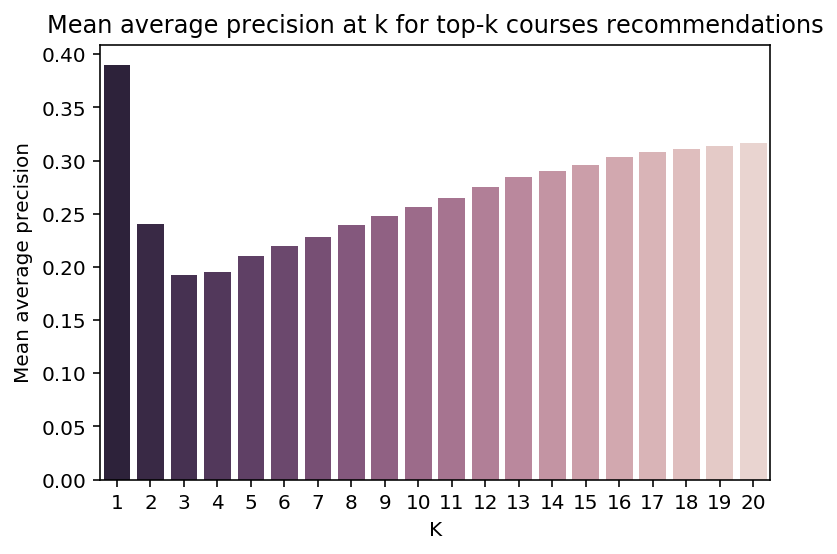

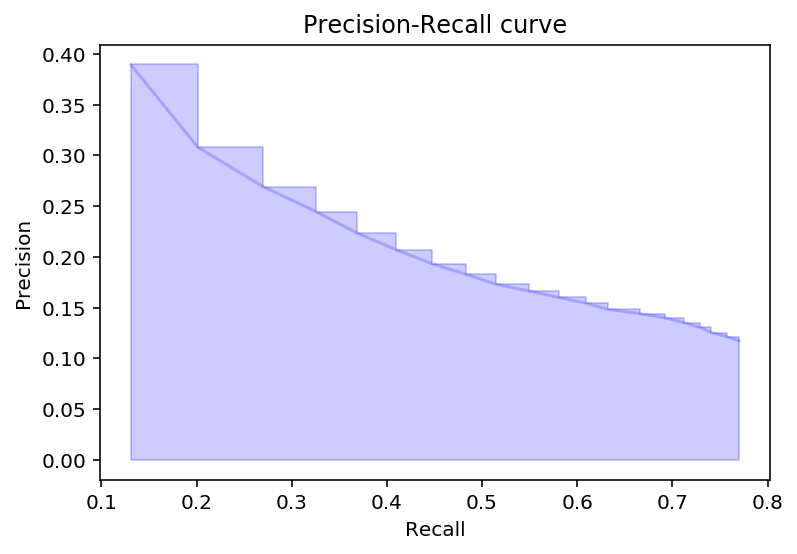

For k = 27 :
For q = 0.998 :
	difference of success rates at 10 - 1: 51.20192307692308

	Success Rate at 1: 38.942308
	MAP at 1: 0.3894230769230769
	Precision at 1: 0.3894230769230769
	Recall at 1: 0.13087225274725273
	F1 score at 1: 0.19590671852073738

	Success Rate at 2: 52.403846
	MAP at 2: 0.2403846153846154
	Precision at 2: 0.3076923076923077
	Recall at 2: 0.2020260989010989
	F1 score at 2: 0.2439067366642655

	Success Rate at 3: 64.182692
	MAP at 3: 0.19310897435897434
	Precision at 3: 0.2676282051282051
	Recall at 3: 0.2678113553113553
	F1 score at 3: 0.26771974889599315

	Success Rate at 4: 71.634615
	MAP at 4: 0.19551282051282046
	Precision at 4: 0.24338942307692307
	Recall at 4: 0.3247424450549451
	F1 score at 4: 0.27824130552791626

	Success Rate at 5: 75.000000
	MAP at 5: 0.21017628205128205
	Precision at 5: 0.22403846153846155
	Recall at 5: 0.36911630036630033
	F1 score at 5: 0.2788353171009777

	Success Rate at 6: 78.846154
	MAP at 6: 0.2174278846153846
	Precision at 6: 

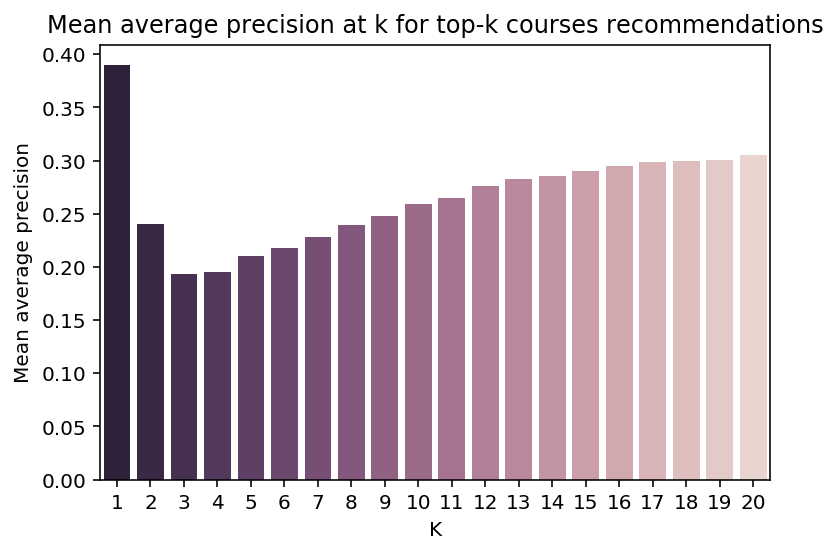

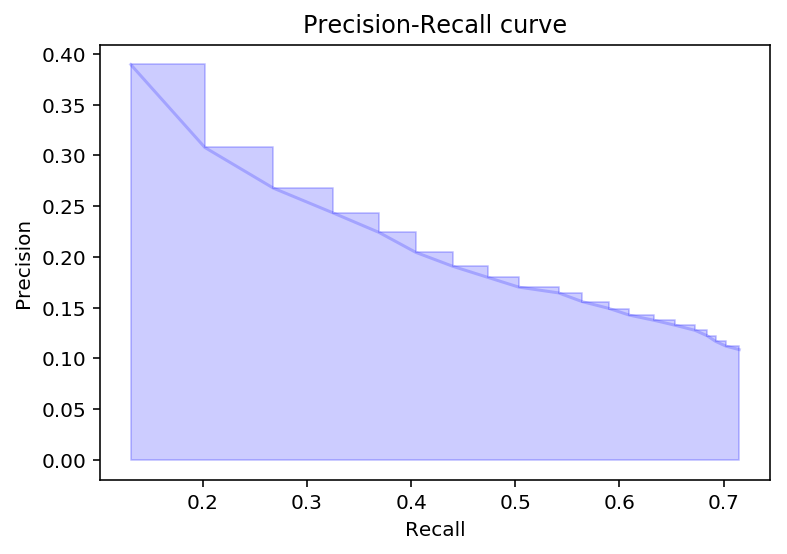

In [13]:
# Baseline + co-enrolment
preds = np.array([ np.array(training_weight_coenrolments(i)) * np.array(nn_weights) for i, nn_weights in enumerate(pred) ])
print_stats_prediction(preds)

# Baseline + grade correlation + co-enrolment
preds = np.array([ np.array(training_weight_coenrolments(i)) * np.array(training_weight_grade_corr(i)) * np.array(nn_weights) for i, nn_weights in enumerate(pred) ])
print_stats_prediction(preds)

# Only baseline
#print_stats_prediction(pred)

# Only co-enrolment
#preds = np.array([ np.array(training_weight_coenrolments(i)) for i, nn_weights in enumerate(pred) ])
#print_stats_prediction(preds)

# Only grade correlations
#preds = np.array([ np.array(training_weight_grade_corr(i)) for i, nn_weights in enumerate(pred) ])
#print_stats_prediction(preds)

# Baseline + grade correlations
#preds = np.array([ np.array(training_weight_grade_corr(i)) * np.array(nn_weights) for i, nn_weights in enumerate(pred) ])
#print_stats_prediction(preds)

# Grade correlations + co-enrolment
#preds = np.array([ np.array(training_weight_coenrolments(i)) * np.array(training_weight_grade_corr(i)) for i, nn_weights in enumerate(pred) ])
#print_stats_prediction(preds)

### Splitting into group1, group2 courses

In [14]:
group1_courses = ["Advanced algorithms", "Advanced computer architecture",
                 "Cryptography and security", "Advanced databases",
                 "Distributed algorithms", "Distributed information systems",
                 "Foundations of software", "Information theory and coding",
                 "Pattern classification and machine learning"]
MIN_COURSES_BY_STUDENT_group1 = 2
MIN_COURSES_BY_STUDENT_group2 = 3

group1_courses_matrix = courses_matrix[group1_courses]
group1_courses_matrix = group1_courses_matrix[np.sum(group1_courses_matrix == 1, axis=1) > MIN_COURSES_BY_STUDENT_group1]
group2_courses_matrix = courses_matrix.drop(group1_courses, axis=1)
group2_courses_matrix = group2_courses_matrix[np.sum(group2_courses_matrix == 1, axis=1) > MIN_COURSES_BY_STUDENT_group2]

training_set_group1, testing_set_group1 = split_data(group1_courses_matrix)
training_set_group2, testing_set_group2 = split_data(group2_courses_matrix)

# Numpify the data
train_np_1 = training_set_group1.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()
test_np_1 = testing_set_group1.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()
train_np_2 = training_set_group2.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()
test_np_2 = testing_set_group2.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()

# the indices of each user
users_group1 = np.array(np.arange(group1_courses_matrix.shape[0])[np.newaxis].T, dtype=np.int32)
users_group2 = np.array(np.arange(group2_courses_matrix.shape[0])[np.newaxis].T, dtype=np.int32)

### Prediction for a student

In [15]:
me = [ 
"Distributed information systems",
"Information theory and coding",
"Pattern classification and machine learning",
"Mobile networks",
"Statistical signal and data processing through applications",
"TCP/IP networking",
"Digital education & learning analytics"]
my_courses = pd.DataFrame(data=0, columns=courses_matrix.columns, index=["Romain"])
my_courses[me] = 1
taken_courses = my_courses.loc["Romain"][my_courses.loc["Romain"] == 1].index.tolist()

my_binary_courses = my_courses.as_matrix()
binary_courses_format = np.array([[1]], dtype=np.int32)

In [16]:
prediction_romain = model.predict(x=[my_binary_courses, binary_courses_format])
preds_romain = np.array([ np.array(training_weight_coenrolments(i)) * np.array(training_weight_grade_corr(i)) * np.array(nn_weights) for i, nn_weights in enumerate(prediction_romain) ])
prediction_romain = np.argsort(preds_romain)

predicted_courses = [courses_matrix.columns[i] for i in prediction_romain[0]]
last_year_courses = list(registrations.xs('2015-2016', level='YearName').index)
predicted_courses = [c for c in predicted_courses if c in last_year_courses and c not in taken_courses]

print("I picked the following courses: \n\t-{} \n\nHence we propose the following: \n\t-{}"
     .format("\n\t-".join(taken_courses), "\n\t-".join(predicted_courses[::-1][:10])))

I picked the following courses: 
	-Digital education & learning analytics
	-Distributed information systems
	-Information theory and coding
	-Mobile networks
	-Pattern classification and machine learning
	-Statistical signal and data processing through applications
	-TCP/IP networking 

Hence we propose the following: 
	-Distributed algorithms
	-Cryptography and security
	-Foundations of software
	-Concurrent algorithms
	-Intelligent agents
	-Program parallelization on PC clusters
	-Advanced computer graphics
	-Biometrics
	-Image processing I
	-Unsupervised and reinforcement learning in neural networks


### Done
- All data gives really bad results (discrimination by section)
- Results are different from one domain to another (BEFORE WEIGHING OUT THE OBLIGATORY COURSES, or courses that are bloat (laboratories etc..., case by case basis ?)
- [They talk a bit about top-N recommendation in this paper (Boi)](http://delivery.acm.org/10.1145/2810000/2800184/p179-maksai.pdf?ip=128.179.189.64&id=2800184&acc=ACTIVE%20SERVICE&key=FC66C24E42F07228%2E7E17DDD1CCA0F75B%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&CFID=1003867347&CFTOKEN=59100520&__acm__=1510214008_777b3b2b2f3763bb6c7aa57bcdcdf49a)
- Move to the new data
- Right precision and recall metrics
- Right test/train se
- Try on like 5 sections with same parameters if still good results
- Doing it by faculty gives same results (for IC)
- Split options and obligatory recommendations
- Quick hard-coded demo for taken courses
- Co-enrolment matrix
- Multiply probability of taking course at output with proba that a student takes the predicted course before argsort (mean of coenrolment inbetween one prediction and ALL courses the student took). Then compare baseline with new system.
- Correlation grades used by multiply to each pair of course, and put it in the pipeline. Then compare baseline with this one
- Try by faculty (all courses from ENAC for example, IC is not, and all good)
- Get results by faculties, wait all results to do model selection
- Choose model based on f1 score probably
- Differentiate inbetween metrics
- Success rate inbetween taking one course and 2 courses

### Questions

### To do
- Co-enrolment matrix is similar to collab filtering -> map the three to one class of existing algos
- Porting code to usable codebase for next coder ?
- Replace names by ids from DB by production code day
- Automatic best parameters detection ? Need a cluster ? Grid Search ?
- start working on demo, boxes for each course and recommend stuff
- Add justification to recommendation: "students who took your course also took: ..."